## RNN for Skyrmion trajectories prediction

**Imports**

In [104]:
# Standard imports
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import trackpy as tp
from tqdm import tqdm  # for progress bar

# import functions
from my_functions import *

import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

**Read the data**

In [105]:
directory = 'Rec_EDGE_300K_1L_50MA.out'
data = pd.read_csv(directory + '/filled_trajectories.csv')
data = data.drop(data.columns[0], axis=1)
no_skyrmions = data[data['frame'] == 0].shape[0]

data

,y,x,frame,particle
0,24.420047,61.809992,0.0,0.0
1,31.518261,109.009463,0.0,1.0
2,51.658864,41.007417,0.0,2.0
3,60.994689,82.173861,0.0,3.0
4,61.572998,129.252586,0.0,4.0
...,...,...,...,...
11995,26.838018,9158.734705,799.0,10.0
11996,92.153535,8909.539660,799.0,11.0
11997,160.675052,8812.401110,799.0,12.0
11998,156.663224,8600.194927,799.0,13.0


In [106]:
# this function splits the data in sequences
# each sequence is n_steps long and outputs a single value, i.e. the next time frame
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [107]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

## Experiment 1: predict next frame given n previous time steps

In this experiment, the aim is to predict the next frame given a series of length n of the previous time steps. We will be using a simple RNN model for this. It might be worth trying to use LSTMs as well.

In [4]:
# first, scale the data x and y separately as they have very different ranges

min_max_scaler_x = preprocessing.MinMaxScaler()
min_max_scaler_y = preprocessing.MinMaxScaler()

data_scaled = data.copy()

data_scaled['x'] = min_max_scaler_x.fit_transform(np.reshape(data['x'].values.astype(float), (-1, 1)))
data_scaled['y'] = min_max_scaler_y.fit_transform(np.reshape(data['y'].values.astype(float), (-1, 1)))

data_scaled

,y,x,frame,particle
0,0.065298,0.003366,0.0,0.0
1,0.105854,0.008537,0.0,1.0
2,0.220930,0.001087,0.0,2.0
3,0.274271,0.005597,0.0,3.0
4,0.277575,0.010755,0.0,4.0
...,...,...,...,...
11995,0.079113,1.000000,799.0,10.0
11996,0.452300,0.972699,799.0,11.0
11997,0.843805,0.962057,799.0,12.0
11998,0.820883,0.938808,799.0,13.0


**Particles used for training**


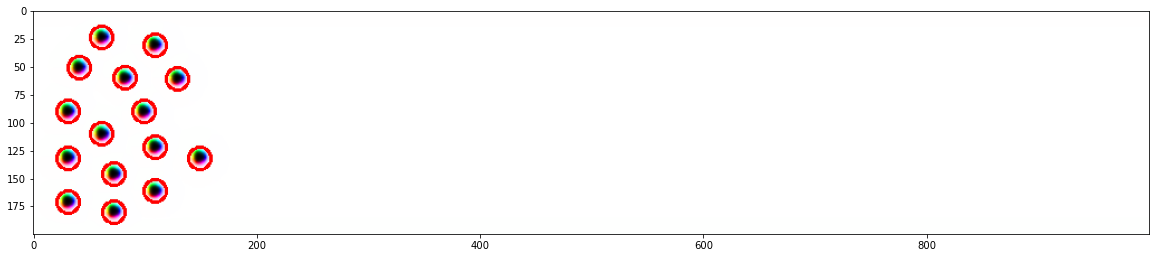

Getting frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 122.80it/s]


In [5]:
# show which frames we will be working on
print('**Particles used for training**')
show_tracked(data, directory)

# format data so that it is in the format (frame, next_frame)
frames = np.array(get_frames(data_scaled))

# data in columns ['frame', 'next_frame']
df = pd.DataFrame(columns=['frame', 'next_frame'])

for i in range(1, len(frames)):
    df = df.append({'frame': frames[i-1], 'next_frame': frames[i]}, ignore_index=True)

In [6]:
# split into train and test sets
# we will use one third for testing
train_size = int(len(frames) * 0.67)
test_size = len(frames) - train_size
train, test = frames[0:train_size,:], frames[train_size:len(frames),:]
print(f'Train length: {len(train)}')
print(f'Test length: {len(test)}')

Train length: 536
Test length: 264


In [7]:
# choose a number of time steps
n_steps = 5
# convert into input/output
X_train, y_train = split_sequences(train, n_steps)
X_test, y_test = split_sequences(test, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X_train.shape[2]

In [8]:
# define model
model = Sequential()
model.add(SimpleRNN(128, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(SimpleRNN(512, activation='relu', return_sequences=True))
model.add(SimpleRNN(128, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mae')

In [9]:
# fit model
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=100, batch_size=10)

Train on 531 samples, validate on 259 samples
Epoch 1/100
531/531 [==============================] - 1s 2ms/step - loss: 0.0863 - val_loss: 0.1420
Epoch 2/100
531/531 [==============================] - 0s 838us/step - loss: 0.0367 - val_loss: 0.1193
Epoch 3/100
531/531 [==============================] - 0s 811us/step - loss: 0.0328 - val_loss: 0.1106
Epoch 4/100
531/531 [==============================] - 0s 879us/step - loss: 0.0272 - val_loss: 0.1214
Epoch 5/100
531/531 [==============================] - 0s 860us/step - loss: 0.0235 - val_loss: 0.1128
Epoch 6/100
531/531 [==============================] - 0s 896us/step - loss: 0.0227 - val_loss: 0.1074
Epoch 7/100
531/531 [==============================] - 0s 794us/step - loss: 0.0231 - val_loss: 0.1196
Epoch 8/100
531/531 [==============================] - 0s 804us/step - loss: 0.0217 - val_loss: 0.1055
Epoch 9/100
531/531 [==============================] - 0s 813us/step - loss: 0.0242 - val_loss: 0.1280
Epoch 10/100
531/531 [=======

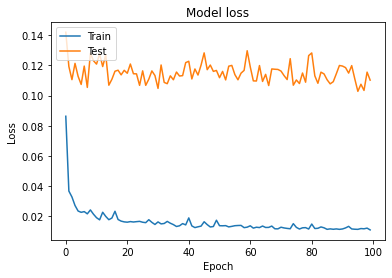

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [11]:
print('The model performance for X_train')
pred_train = evaluate(X_train, y_train, model)
print('The model performance for X_test')
pred_test = evaluate(X_test, y_test, model)

The model performance for X_train
--------------------------------------
RMSE is 0.013823624168781417
R2 score is 0.9755889379831347


The model performance for X_test
--------------------------------------
RMSE is 0.15121961175029253
R2 score is -2.328847618184767




In [12]:
pred_train_df = get_predictions_df(pred_train)
pred_test_df = get_predictions_df(pred_test)

Prediction to dataframe: 100%|█████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:04<00:00, 58.56it/s]


In [13]:
pred_train_unscaled = pred_train_df.copy()
pred_test_unscaled = pred_test_df.copy()

pred_train_unscaled['x'] = min_max_scaler_x.inverse_transform(np.reshape(pred_train_unscaled['x'].values.astype(float), (-1, 1)))
pred_train_unscaled['y'] = min_max_scaler_y.inverse_transform(np.reshape(pred_train_unscaled['y'].values.astype(float), (-1, 1)))

pred_test_unscaled['x'] = min_max_scaler_x.inverse_transform(np.reshape(pred_test_unscaled['x'].values.astype(float), (-1, 1)))
pred_test_unscaled['y'] = min_max_scaler_y.inverse_transform(np.reshape(pred_test_unscaled['y'].values.astype(float), (-1, 1)))

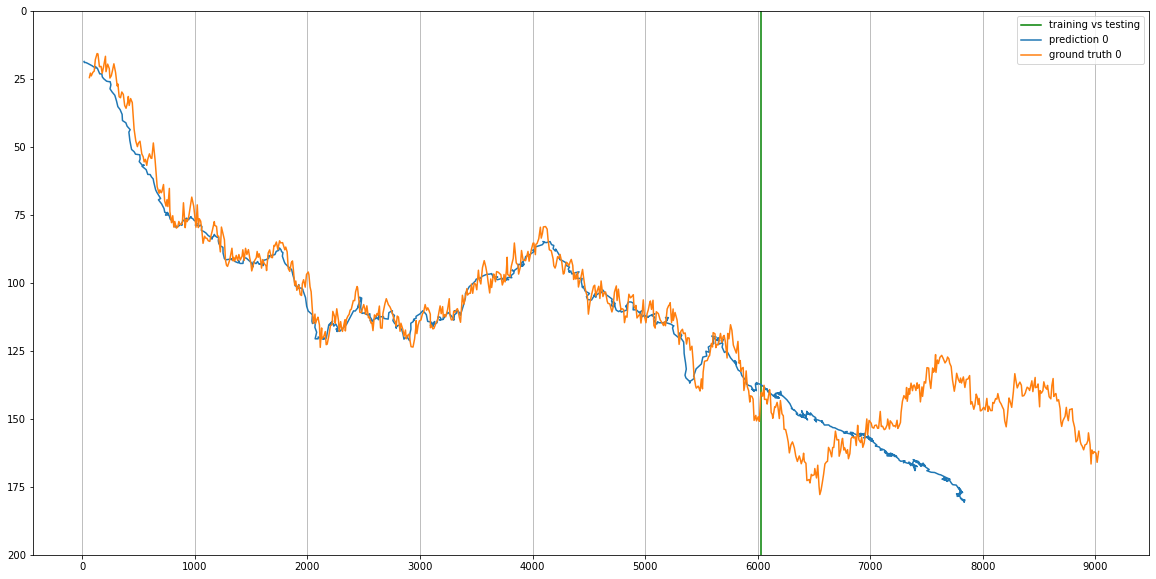

In [14]:
plot_prediction(data, pred_test_unscaled, pred_train_unscaled, ids=[0])

**Observations**

So far, this experiment seems not to yield very good results. This could be likely due to the fact that we are trying to use all the positions in the previous frames to predcit all the future positions and the network might not be learning a complex enough functions to model this behaviour (in particular the interaction and non-interactions between close skyrmions).

Anohter reason as to why this experiment is not yielding good results could be how the data is formatted. Maybe this is not the best way of treating the data.

## Experiment 2: Predict single coordinate

In this experiment, we are still traying to predict a single future frames, but we are focusing on a single coordinate of a single particle, insted of considering all particle and both x and y coordinates.

In [5]:
# the particle and coordinate we are trying to predict
particle = 0
coordinate = 'y'

coordinate_df = data[data['particle'] == particle][coordinate].reset_index(drop=True)
coordinate_df

0       24.420047
1       22.786106
2       23.797221
3       22.500377
4       22.045133
          ...    
795    162.759434
796    162.037060
797    162.559788
798    165.976863
799    161.975156
Name: y, Length: 800, dtype: float64

In [6]:
# scale the data
min_max_scaler = preprocessing.MinMaxScaler()

coordinates_scaled = coordinate_df.copy()

coordinates_scaled = min_max_scaler.fit_transform(np.reshape(coordinate_df.values.astype(float), (-1, 1)))

coordinates_scaled.shape

(800, 1)

In [7]:
# split into train and test sets
train_size = int(len(coordinates_scaled) * 0.67)
test_size = len(coordinates_scaled) - train_size
train, test = coordinates_scaled[0:train_size,:], coordinates_scaled[train_size:len(coordinates_scaled),:]
print(f'Train length: {len(train)}')
print(f'Test length: {len(test)}')

Train length: 536
Test length: 264


In [8]:
# choose a number of time steps
n_steps = 1
# convert into input/output
X_train, y_train = split_sequences(train, n_steps)
X_test, y_test = split_sequences(test, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X_train.shape[2]

In [9]:
# define model
model = Sequential()
model.add(SimpleRNN(128, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(SimpleRNN(512, activation='relu', return_sequences=True))
model.add(SimpleRNN(128, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mae')

In [10]:
# fit model
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=100)

Train on 535 samples, validate on 263 samples
Epoch 1/100
535/535 [==============================] - 1s 981us/step - loss: 0.1508 - val_loss: 0.1351
Epoch 2/100
535/535 [==============================] - 0s 186us/step - loss: 0.0353 - val_loss: 0.0486
Epoch 3/100
535/535 [==============================] - 0s 173us/step - loss: 0.0219 - val_loss: 0.0460
Epoch 4/100
535/535 [==============================] - 0s 170us/step - loss: 0.0206 - val_loss: 0.0220
Epoch 5/100
535/535 [==============================] - 0s 166us/step - loss: 0.0180 - val_loss: 0.0240
Epoch 6/100
535/535 [==============================] - 0s 170us/step - loss: 0.0190 - val_loss: 0.0160
Epoch 7/100
535/535 [==============================] - 0s 166us/step - loss: 0.0171 - val_loss: 0.0154
Epoch 8/100
535/535 [==============================] - 0s 166us/step - loss: 0.0178 - val_loss: 0.0186
Epoch 9/100
535/535 [==============================] - 0s 162us/step - loss: 0.0175 - val_loss: 0.0364
Epoch 10/100
535/535 [=====

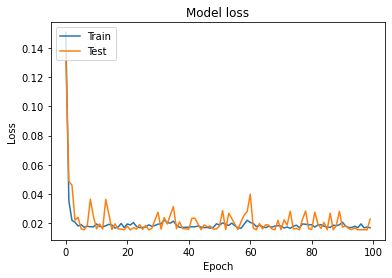

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [12]:
print('The model performance for X_train')
pred_train = evaluate(X_train, y_train, model)
print('The model performance for X_test')
pred_test = evaluate(X_test, y_test, model)

The model performance for X_train
--------------------------------------
RMSE is 0.023139381120466523
R2 score is 0.9798331574159289


The model performance for X_test
--------------------------------------
RMSE is 0.027444399855538062
R2 score is 0.8479112437760296




In [13]:
pred_train_unscaled = pred_train.copy()
pred_test_unscaled = pred_test.copy()

pred_train_unscaled = min_max_scaler.inverse_transform(np.reshape(pred_train_unscaled.astype(float), (-1, 1)))

pred_test_unscaled = min_max_scaler.inverse_transform(np.reshape(pred_test_unscaled.astype(float), (-1, 1)))

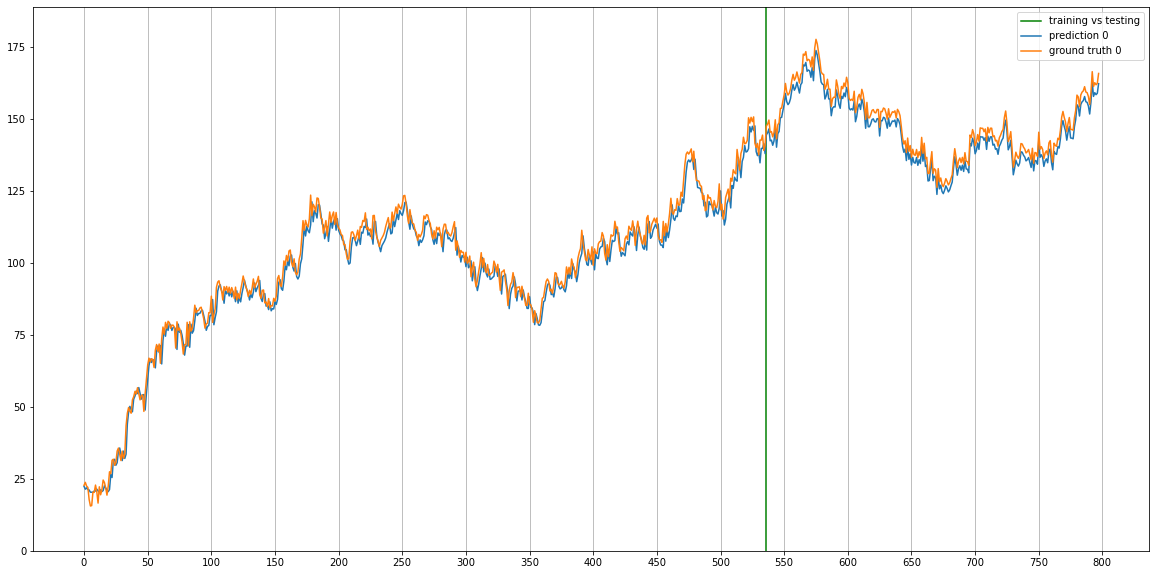

In [14]:
plt.figure(figsize=(20, 10))
plt.grid(True, axis='x')
plt.xticks(np.arange(0, 801, 50))
plt.ylim(0, max(data[coordinate])+1)

plt.axvline(x=train_size, ymin=0, ymax=1, label='training vs testing', color='g')
y = np.concatenate((pred_train_unscaled, pred_test_unscaled))
x = np.arange(y.shape[0]).reshape((y.shape[0], 1))

plt.plot(x, y, label='prediction ' + str(particle), color='tab:blue')
plt.plot(x, data[data['particle'] == particle][coordinate][n_steps:-n_steps], label='ground truth ' + str(particle), color='tab:orange')

plt.legend()

**Observations**

This experiment is yielding the expected results as we have already seen in the experiments for linear and polynomial regression that there is a close-to-linear relationship between one frame and the next and this is taking as input n = 5 frames to predict the next one, so this should in fact be quite precise.

With n = 1, it seems the parformance is even better.

A few questions to address are:
1. How many time steps in the past do we need in order to get a good prediction for the next time step?
2. How many time steps in the future can we predict?
3. How does it preform so well even without considering theinteraction with other particles? Are particles almost independent in such a simple ferromagnet?

## Experiment 3: predicting multiple frames in the future

This is the same as experiment 2, but here we want to predict more time frames in the future.

In [108]:
# the particle and coordinate we are trying to predict
particle = 0
coordinate = 'y'

coordinate_df = data[data['particle'] == particle][coordinate].reset_index(drop=True)
coordinate_df

0       24.420047
1       22.786106
2       23.797221
3       22.500377
4       22.045133
          ...    
795    162.759434
796    162.037060
797    162.559788
798    165.976863
799    161.975156
Name: y, Length: 800, dtype: float64

In [109]:
# scale the data
min_max_scaler = preprocessing.MinMaxScaler()

coordinates_scaled = coordinate_df.copy()

coordinates_scaled = min_max_scaler.fit_transform(np.reshape(coordinate_df.values.astype(float), (-1, 1)))

coordinates_scaled.shape

(800, 1)

In [110]:
# split into train and test sets
train_size = int(len(coordinates_scaled) * 0.67)
test_size = len(coordinates_scaled) - train_size
train, test = coordinates_scaled[0:train_size,:], coordinates_scaled[train_size:len(coordinates_scaled),:]
print(f'Train length: {len(train)}')
print(f'Test length: {len(test)}')

Train length: 536
Test length: 264


In [111]:
# choose a number of time steps
n_steps_in, n_steps_out = 10, 30
# convert into input/output
X_train, y_train = split_sequence(train, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X_train.shape[2]

y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])

In [163]:
# define model
model = Sequential()
model.add(SimpleRNN(32, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(SimpleRNN(16, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae')

In [164]:
# fit model
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=250)

Train on 497 samples, validate on 225 samples
Epoch 1/250
497/497 [==============================] - 0s 738us/step - loss: 0.4303 - val_loss: 0.5751
Epoch 2/250
497/497 [==============================] - 0s 122us/step - loss: 0.3235 - val_loss: 0.4205
Epoch 3/250
497/497 [==============================] - 0s 138us/step - loss: 0.2282 - val_loss: 0.2866
Epoch 4/250
497/497 [==============================] - 0s 151us/step - loss: 0.1603 - val_loss: 0.2129
Epoch 5/250
497/497 [==============================] - 0s 124us/step - loss: 0.1107 - val_loss: 0.1353
Epoch 6/250
497/497 [==============================] - 0s 114us/step - loss: 0.0805 - val_loss: 0.1041
Epoch 7/250
497/497 [==============================] - 0s 104us/step - loss: 0.0638 - val_loss: 0.0931
Epoch 8/250
497/497 [==============================] - 0s 108us/step - loss: 0.0539 - val_loss: 0.0700
Epoch 9/250
497/497 [==============================] - 0s 116us/step - loss: 0.0465 - val_loss: 0.0570
Epoch 10/250
497/497 [=====

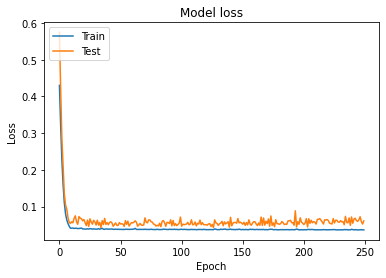

In [165]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [166]:
print('The model performance for X_train')
pred_train = evaluate(X_train, y_train, model)
print('The model performance for X_test')
pred_test = evaluate(X_test, y_test, model)

The model performance for X_train
--------------------------------------
RMSE is 0.048935804468212336
R2 score is 0.8391491509283093


The model performance for X_test
--------------------------------------
RMSE is 0.07639660958920377
R2 score is -0.19843002714755162




In [167]:
pred_train_unscaled = pred_train.copy()
pred_test_unscaled = pred_test.copy()

pred_train_unscaled = min_max_scaler.inverse_transform(np.reshape(pred_train_unscaled.astype(float), (-1, 1))).reshape(pred_train.shape[0], -1)

pred_test_unscaled = min_max_scaler.inverse_transform(np.reshape(pred_test_unscaled.astype(float), (-1, 1))).reshape(pred_test.shape[0], -1)

In [168]:
X_train_unscaled = X_train.copy()
X_test_unscaled = X_test.copy()

X_train_unscaled = min_max_scaler.inverse_transform(np.reshape(X_train.astype(float), (-1, 1))).reshape(X_train.shape[0], -1)
X_test_unscaled = min_max_scaler.inverse_transform(np.reshape(X_test.astype(float), (-1, 1))).reshape(X_test.shape[0], -1)

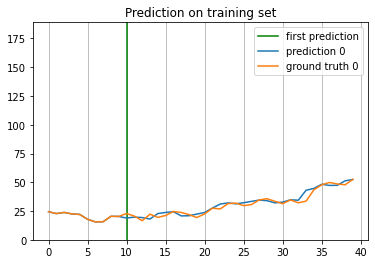

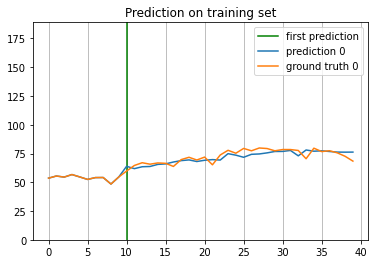

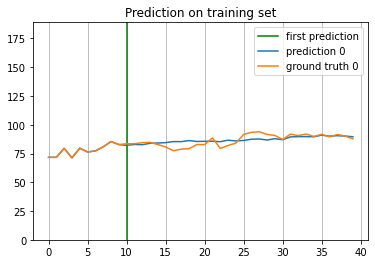

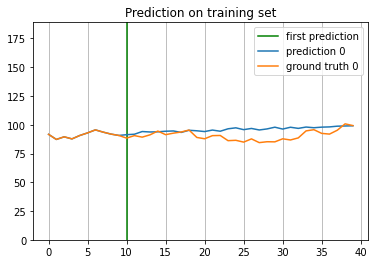

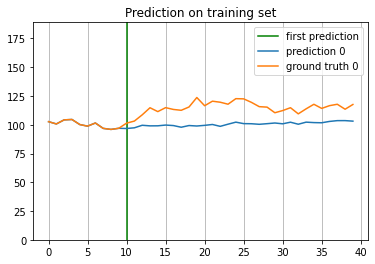

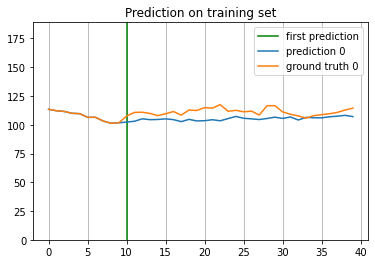

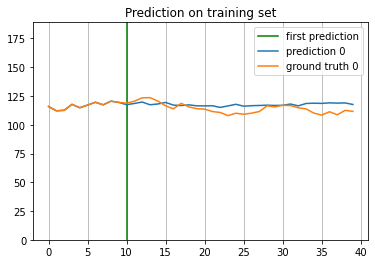

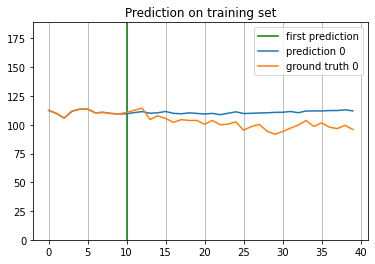

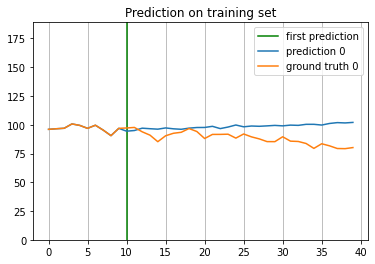

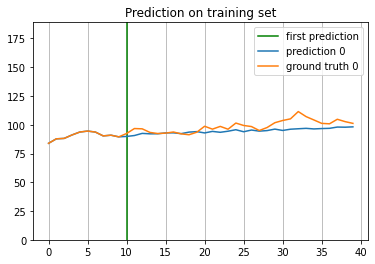

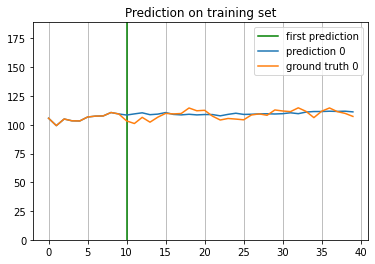

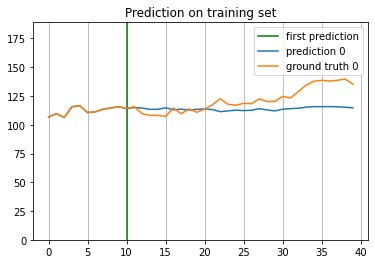

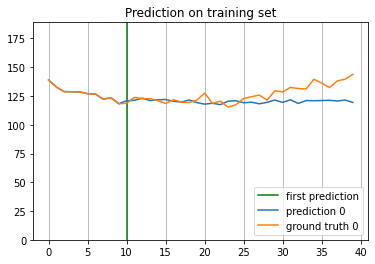

In [169]:
for i in range (0, len(X_train_unscaled), n_steps_in + n_steps_out):
    plt.figure()
    plt.grid(True, axis='x')
    plt.ylim(0, max(data[coordinate])+1)
    plt.title('Prediction on training set')

    plt.axvline(x=n_steps_in, ymin=0, ymax=1, label='first prediction', color='g')
    y = np.concatenate((X_train_unscaled[i], pred_train_unscaled[i]))
    x = np.arange(y.shape[0]).reshape((y.shape[0], 1))

    plt.plot(x, y, label='prediction ' + str(particle), color='tab:blue')
    plt.plot(x, data[data['particle'] == particle][coordinate][i:i+n_steps_in+n_steps_out], label='ground truth ' + str(particle), color='tab:orange')

    plt.legend()

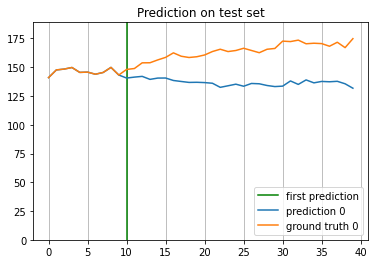

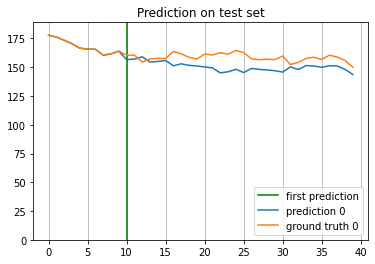

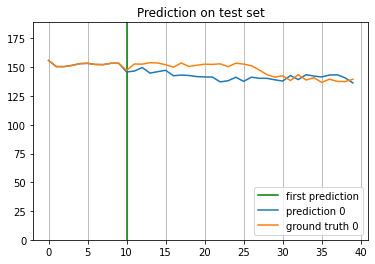

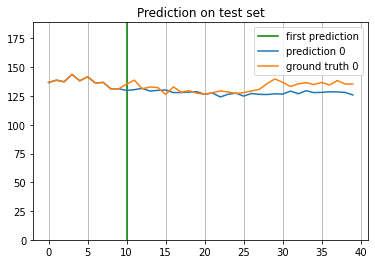

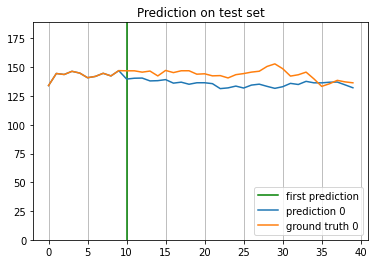

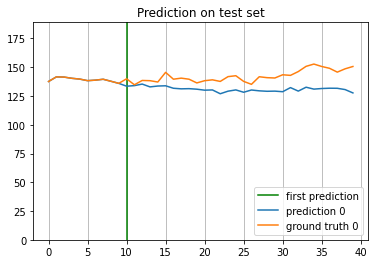

In [170]:
for i in range (0, len(X_test_unscaled), n_steps_in + n_steps_out):
    plt.figure()
    plt.grid(True, axis='x')
    plt.ylim(0, max(data[coordinate])+1)
    plt.title('Prediction on test set')

    plt.axvline(x=n_steps_in, ymin=0, ymax=1, label='first prediction', color='g')
    y = np.concatenate((X_test_unscaled[i], pred_test_unscaled[i]))
    x = np.arange(y.shape[0]).reshape((y.shape[0], 1))

    plt.plot(x, y, label='prediction ' + str(particle), color='tab:blue')
    plt.plot(x, data[data['particle'] == particle][coordinate][train_size+i:train_size+i+n_steps_in+n_steps_out], label='ground truth ' + str(particle), color='tab:orange')

    plt.legend()

**Observations**

This experiment does not yield very good results yet. The prediction can be improved with more tweaking of the RNN architecture and maybe by using an LSTM.

Some interesting questions to address are:
1. How well can a model trained on one coordinate perform on the other coordinate?
2. How well can a model trained on one particle perform on the other particle?
3. What happens if the model is trained on the x-coordinate? This will probably make the model too simple, hence making it not able to predict y-coorinates.
4. How big and small can n_steps_in and n_steps_out be?